<p align="center">
<img src="https://www.uao.edu.co/wp-content/uploads/2024/12/uao-logo-2-04.webp" width=15%>


<h2>UNIVERSIDAD AUTÓNOMA DE OCCIDENTE</strong></h2>
<h3>02/27/2025 CALI - COLOMBIA</strong></h3>
<h3><strong>MAESTRIA EN INTELIGENCIA ARTIFICIAL Y CIENCIA DE DATOS</strong></h3>
<h3><strong>ETL (EXTRACT, TRANSFORM AND LOAD)</strong></h3>
<h3><strong>ENTREGA 2.0. </strong> TRABAJO FINAL - Ejercicio de Transformacion de datos usando Dataset de produccion</h3>
<h3><strong>Profesor:</strong> JAVIER ALEJANDRO VERGARA ZORRILLA</h3>
<h3><strong>Alumno:</strong></h3>

<li><font color='lighblue'> 22500214 Yoniliman Galvis Aguirre </font></li>

---
# Verificar Kernel
Verificamos si el ambiente jupyter esta ejecutando el kernel en el entorno correcto, el resultado de las dos rutas debe coincidir, de lo contrario se debe de cambiar el kernel del jupyter notebook, una opcion es correr el enviroment desde poetry, en la terminal ejecute:

```bash
poetry run jupyter notebook
```
esto abrirá una version web de jupyter, en otro caso cambie el kernel y use los venv disponibles

Si el notebook esta ejecutando un kernel diferente a la carpeta del proyecto cuando instale librerías se presentarán fallas en la ejecucion del código del notebook

In [35]:
import subprocess

# Ejecutar el comando de poetry desde Python
result = subprocess.run(['poetry', 'env', 'info', '--path'], capture_output=True, text=True)

# Verificar si el comando se ejecutó correctamente
if result.returncode == 0:
    print("Ruta del entorno virtual:", result.stdout.strip())
else:
    print("Error al ejecutar el comando:", result.stderr)

Ruta del entorno virtual: /home/ygalvis/Documents/Study/ETL_project/.venv


In [1]:
import subprocess
import shutil

def get_poetry_env_path():
    try:
        # Ejecutar el comando de poetry desde Python
        result = subprocess.run(['poetry', 'env', 'info', '--path'], capture_output=True, text=True, check=True)
        # Obtener la ruta del entorno virtual
        env_path = result.stdout.strip()
        return env_path
    except subprocess.CalledProcessError as e:
        print(f"Error al ejecutar el comando de poetry: {e.stderr}")
        return None

def get_active_python_path():
    # Obtener la ruta del ejecutable de Python activo
    python_path = shutil.which("python")
    return python_path

def main():
    poetry_env_path = get_poetry_env_path()
    active_python_path = get_active_python_path()

    if poetry_env_path:
        print(f"El entorno virtual activo de poetry está en: {poetry_env_path}")
    else:
        print("No se pudo obtener la ruta del entorno virtual de poetry.")

    if active_python_path:
        print(f"El entorno virtual activo del kernel en el notebook está en: {active_python_path}")
    else:
        print("No se pudo obtener la ruta del ejecutable de Python activo.")

if __name__ == "__main__":
    main()

El entorno virtual activo de poetry está en: /home/ygalvis/Documents/Study/ETL_project/.venv
El entorno virtual activo del kernel en el notebook está en: /home/ygalvis/Documents/Study/ETL_project/.venv/bin/python


# Segunda Entrega: Transformacion de datos

Carga de librerías necesarias para el analisis de los datos

In [2]:
# Data managment
# ==============================================================================
import yaml #manejo de archivos de configuracion .yaml
import psycopg2 #conector de sql, postgresql, mysql, mariaDB
from psycopg2 import sql #driver para postgresql en python
from sqlalchemy import create_engine, text #librería ORM (Object relational Mapper/Mappingtool) para facilitar trabajos con estructura de la DB y los datos

import pandas as pd #permite el manejo, análisis de datos en python
import numpy as np #computacion científica y matemática
import shutil as sht
import random
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
import re
from IPython.display import display

from sklearn import datasets
from __future__ import print_function
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

# Graphics
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly as plty
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

# import warnings; warnings.simplefilter('ignore')
warnings.filterwarnings('ignore') # Avoid warnings for out of date libraries
%matplotlib inline

separador = "\n" + "*"*100 + "\n"

# Cargar parámetros de la DB
Usando el archivo de config.yam, tomamos los parametros de configuracion, los asigna a etiquetas y los carga en variables internas

In [3]:
def load_config(file_path="credentials/ETLprj_config.yaml"):
    with open(file_path, "r") as file:
        return yaml.safe_load(file)

In [4]:
config = load_config()
db_config = config["database"]

# Load credentials
db_user = db_config["user"]
db_password = db_config["password"]
db_host = db_config["host"]
db_port = db_config["port"]
db_name = db_config["name"]

# Asignando las variables
se crea el objeto de conexion con la base de datos

#Posgresql

para acceder a la base de datos debe ingresar como super user, el ingresará con el usuario del sistema y el password es elmismo del sistema:

<code> $ sudo su - postgres</code>

In [5]:
# DB connection
conn = psycopg2.connect(
    dbname="postgres",
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)
conn.autocommit = True

## Crear conexión a la base de datos

In [6]:
# crear conexión a la base de datos
engine = create_engine(f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}")

# Leer y Cargar Datos
Leemos los datos desde la base de datos y los mostramos

In [7]:
# Leer datos de la tabla
with engine.connect() as conn:
    # Leer datos de la tabla y configurar la zona horaria a 'America/Bogota'
    conn.execute(text("SET TIMEZONE TO 'America/Bogota';"))
     # Ejecutar la consulta
    result = conn.execute(text("SELECT * FROM dataset LIMIT 10;"))
    rows = result.fetchall()

# Mostrar los resultados
print("Datos en 'ETL_prj.public.dataset':")
for row in rows:
    print(row)

Datos en 'ETL_prj.public.dataset':
(1, datetime.datetime(2025, 2, 27, 7, 34, 21, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))), 'BYBAGDDIM', '87426', 'F', 'C', 'PMX', 'MD1M66', 'kg', 1.0, 0)
(2, datetime.datetime(2025, 2, 5, 6, 57, 51, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))), 'BXWAGDD6N', '87426', 'F', 'C', 'PMX', 'MD1M66', 'kg', 1.003703704, 0)
(3, datetime.datetime(2025, 2, 5, 2, 7, 48, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))), '9NGAGDD6M', '87426', 'F', 'C', 'PMX', 'MD1M66', 'kg', 0.996296296, 0)
(4, datetime.datetime(2025, 2, 4, 23, 4, 32, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))), 'XT7AGDD67', '87426', 'F', 'C', 'PMX', 'MD1M66', 'kg', 1.014814815, 0)
(5, datetime.datetime(2025, 2, 4, 17, 45, 15, tzinfo=datetime.timezone(datetime.timedelta(days=-1, seconds=68400))), 'V9EAGDD66', '87426', 'F', 'C', 'PMX', 'MD1M66', 'kg', 0.97037037, 0)
(6, datetime.datetime(2025, 2, 4, 15, 

# Cargamos los datos a un Dataframe haciendo una consulta simple

In [8]:
with engine.connect() as conn:
    df = pd.read_sql("SELECT * FROM dataset", conn)
df.head(10)

,id,DateTime,ID,Prod_ID,Type,Train,Unit,Phase_ID,EU,Value,Verify
0,1,2025-02-27 12:34:21+00:00,BYBAGDDIM,87426,F,C,PMX,MD1M66,kg,1.000000,0
1,2,2025-02-05 11:57:51+00:00,BXWAGDD6N,87426,F,C,PMX,MD1M66,kg,1.003704,0
2,3,2025-02-05 07:07:48+00:00,9NGAGDD6M,87426,F,C,PMX,MD1M66,kg,0.996296,0
3,4,2025-02-05 04:04:32+00:00,XT7AGDD67,87426,F,C,PMX,MD1M66,kg,1.014815,0
4,5,2025-02-04 22:45:15+00:00,V9EAGDD66,87426,F,C,PMX,MD1M66,kg,0.970370,0
5,6,2025-02-04 20:15:41+00:00,GZ7AGDD65,87426,F,C,PMX,MD1M66,kg,0.988889,0
6,7,2025-02-04 16:36:37+00:00,RQVAGDD65,87426,F,C,PMX,MD1M66,kg,1.000000,0
7,8,2025-02-03 23:31:57+00:00,FLBAGDD5M,87426,F,C,PMX,MD1M66,kg,1.003704,0
8,9,2025-02-03 13:31:47+00:00,E0PAGDD5K,87426,F,C,PMX,MD1M66,kg,0.996296,0
9,10,2025-01-20 23:17:04+00:00,AL3AGCCY0,87426,F,C,PMX,MD1M66,kg,1.003704,0


## Análisis de errores

Buscamos errores en los datos, como la fuente de los datos puede tener errores, vamos a buscar errores y tomar las decisiones necesarias para subsanarlos.

### Columnas categóricas con errores

Una de las situaciones mas complejas es tener columnas categóricas con fallas ya que estas generan datos huerfanos, las columnas con valores pueden procesarse para generar un valor coherente, pero las categóricas es más complejo ya que no se puede generar una categoría aleatoria, se deben usar las columnas hermanas para generar la categoría correcta, sinembargo si e considera que la cantidad de datos es suficiente y la candidad de errores es muy pequeña podemos descartar las filas con fallas categóricas y ahorrar trabajo evitando problemas de mala recategorización posterior, en especial que una vez se recategorizan en un dataset grande se pierden de vista las filas editadas y si estan ma categorizadas pueden causar sesgos o fallas de la fuente cuando estas se usan en el entrenamiento de IA.

In [9]:
# Definir funcion para localizar errores en el dataset

def Count_ID_Err(df, buscar_en="categoricas", separador="-"*50):
    """
    Identificamos los errores (#VALUE! o NaN) en columnas categóricas, numéricas o todas,
    contamos los IDs únicos con errores, calculamos el porcentaje y devolvemos las filas que están afectadas.

    Parámetros:
    - df: DataFrame -> El conjunto de datos a analizar enun pandas Dataframe.
    - buscar_en: str -> Definimos en qué columnas vamos a buscar errores:
        - "categoricas" -> Solo buscamos en las columnas categóricas (default).
        - "numericas" -> Solo buscamos en las columnas numéricas.
        - "todas" -> Buscamos en todas las columnas de dataframe.
    - separador: str -> Usar un Separador visual para impresión (opcional), si no se pasa alguno.

    Retorna:
    - df_ids_con_errores: DataFrame -> Filas de IDs afectados por errores.
    """

    # Seleccionar columnas según el parámetro buscar_en
    if buscar_en == "categoricas":
        columnas_a_buscar = df.select_dtypes(include=['object']).columns
    elif buscar_en == "numericas":
        columnas_a_buscar = df.select_dtypes(include=['number']).columns
    elif buscar_en == "todas":
        columnas_a_buscar = df.columns
    else:
        raise ValueError("Encontramos que hay una opción inválida. Para 'buscar_en' debes usar 'categoricas', 'numericas' o 'todas'.")

    # Contamos la cantidad total de IDs únicos en el dataset
    total_ids_unicos = df['ID'].nunique()

    # Filtramos filas con errores en las columnas seleccionadas (#VALUE! o NaN)
    df_errores = df[df[columnas_a_buscar].isna().any(axis=1) | 
                    df[columnas_a_buscar].apply(lambda x: x.astype(str).str.contains("#VALUE!", na=False)).any(axis=1)]

    # Contamos la cantidad de IDs únicos con errores
    ids_con_errores = df_errores['ID'].nunique()

    # Calculamos el porcentaje de IDs con errores
    porcentaje_errores = (ids_con_errores / total_ids_unicos) * 100

    # Mostramos los resultados obtenidos
    print(f"{separador}\nCantidad total de IDs únicos: {total_ids_unicos}")
    print(f"Cantidad de IDs únicos con errores en {buscar_en}: {ids_con_errores}")
    print(f"Porcentaje de IDs con errores en {buscar_en}: {porcentaje_errores:.2f}%\n{separador}")

    # Filtramos todas las filas donde el ID de los errores aparece en el dataset original
    df_ids_con_errores = df[df['ID'].isin(df_errores['ID'])]

    return df_ids_con_errores

In [10]:
df_con_errores = Count_ID_Err(df, buscar_en="categoricas", separador=separador)
df_con_errores


****************************************************************************************************

Cantidad total de IDs únicos: 14876
Cantidad de IDs únicos con errores en categoricas: 19
Porcentaje de IDs con errores en categoricas: 0.13%

****************************************************************************************************



,id,DateTime,ID,Prod_ID,Type,Train,Unit,Phase_ID,EU,Value,Verify
33397,33398,2025-01-15 15:49:37+00:00,YZJAGCCV8,#VALUE!,X,A,PMX,MD1M66,kg,0.999918,0
33398,33399,2025-01-15 10:04:49+00:00,T7AAGCCV7,#VALUE!,X,A,PMX,MD1M66,kg,0.999918,0
33399,33400,2025-01-15 03:55:15+00:00,YANAGCCUS,#VALUE!,X,A,PMX,MD1M66,kg,0.990099,0
33400,33401,2024-07-23 12:47:46+00:00,KR4AG009L,#VALUE!,X,A,PMX,MD1M66,kg,1.000008,0
33401,33402,2024-07-23 08:40:00+00:00,LLIAG009K,#VALUE!,X,A,PMX,MD1M66,kg,0.993342,0
...,...,...,...,...,...,...,...,...,...,...,...
220189,220190,2024-05-17 20:49:17+00:00,41XAFZZ86,#VALUE!,X,B,TMX,MVTM,cP,1.144000,0
220190,220191,2024-02-16 09:20:33+00:00,X2SAFXXT7,#VALUE!,X,B,TMX,MVTM,cP,0.974545,0
220191,220192,2025-01-15 14:03:57+00:00,0XKAGCCV8,#VALUE!,X,B,TMX,MPHM,pH,1.020833,0
220192,220193,2024-02-15 17:44:22+00:00,P9QAFXXT4,#VALUE!,X,B,TMX,MPHM,pH,0.995833,0


### Tratamiento de Errores Categóricos

Como hemos observado, en nuestro Dataset tenemos 14876 lotes de los cuales 19 tienen errores en la categoría de ID de producto, eso significa que no conocemos que producto fúe el fabricado, esto corresponde al 0.13% del dataset lo cual es una cantidad que podemos considerar bastante pequeña.

Ya que el dataset es suficientemente grande podemos eliminar estas filas sin necesidad de afectar la data y en cambio intentar categorizar estos productos puede causar perdida de integridad del dataset, procedemos a eliminarlo:

In [11]:
# Obtenemos los IDs que tienen errores
ids_con_errores = df_con_errores['ID'].unique()

# Eliminamos del dataset todas las filas cuyos IDs están en la lista de errores
df = df[~df['ID'].isin(ids_con_errores)]

# Verificamos si se eliminaron correctamente las filas con errores
df_con_errores = Count_ID_Err(df)

--------------------------------------------------
Cantidad total de IDs únicos: 14857
Cantidad de IDs únicos con errores en categoricas: 0
Porcentaje de IDs con errores en categoricas: 0.00%
--------------------------------------------------


### Tratamiento de Errores no Categóricos

Igual que las categorías las columnas de valores pueden tener valores nulos o faltantes, vamos a usar la funcion que creamos para buscar los IDs con valores faltantes

In [12]:
df_con_errores = Count_ID_Err(df, buscar_en="numericas", separador=separador)


****************************************************************************************************

Cantidad total de IDs únicos: 14857
Cantidad de IDs únicos con errores en numericas: 0
Porcentaje de IDs con errores en numericas: 0.00%

****************************************************************************************************



### Verificacion de las  faltantes

Verificamos una ultima vez para observar si el dataset ya está limpio

In [13]:
df_con_errores = Count_ID_Err(df, buscar_en="todas", separador=separador)


****************************************************************************************************

Cantidad total de IDs únicos: 14857
Cantidad de IDs únicos con errores en todas: 0
Porcentaje de IDs con errores en todas: 0.00%

****************************************************************************************************



In [14]:
df.head()

,id,DateTime,ID,Prod_ID,Type,Train,Unit,Phase_ID,EU,Value,Verify
0,1,2025-02-27 12:34:21+00:00,BYBAGDDIM,87426,F,C,PMX,MD1M66,kg,1.000000,0
1,2,2025-02-05 11:57:51+00:00,BXWAGDD6N,87426,F,C,PMX,MD1M66,kg,1.003704,0
2,3,2025-02-05 07:07:48+00:00,9NGAGDD6M,87426,F,C,PMX,MD1M66,kg,0.996296,0
3,4,2025-02-05 04:04:32+00:00,XT7AGDD67,87426,F,C,PMX,MD1M66,kg,1.014815,0
4,5,2025-02-04 22:45:15+00:00,V9EAGDD66,87426,F,C,PMX,MD1M66,kg,0.970370,0


## Tratamiento de texto en columnas categoricas

Uno de los problemas más dificiles de ientificar es cuando valores en las columnas categóricas tienen errores de tipografía, por ejemplo algun espacio antes o despues de la categoría ó contengan mayusculas, siempre es buena idea asegurarse que estas columas esten normalizadas, así que vamos a asegurarnos que no tengan espacios adicionales, puntuacion al final y estén en minusculas.

In [15]:
# Función para limpiar columnas categóricas

def Cat_columns_clean(df):
    """
    Normalizamos las columnas categóricas eliminando:
    - Espacios en blanco antes y después si existen
    - Puntuación al final de los valores si existe
    - Convierte todo a minúsculas si es necesario

    Parámetros:
    - df: DataFrame -> Dataframe a limpiar.

    Retorna:
    - df_limpio: DataFrame -> Dataset con columnas categóricas limpias.
    """
    # Identificamos las columnas categóricas (tipo 'object') (excluyendo datetime)
    columnas_categoricas = df.select_dtypes(include=['object']).columns
    
    cambios_realizados = 0  # Contador de cambios

    # Función para normalizar cada valor si es necesario
    def limpiar_texto(texto):
        nonlocal cambios_realizados  # Permitir modificar la variable dentro de la función

        # Si el valor no es un string (ejemplo: NaN, datetime, números), devolverlo tal cual
        if not isinstance(texto, str):
            return texto
        
        texto_original = str(texto)  # Guardamos la versión original y Convertir a texto en caso de ser otro tipo
        texto = texto.strip()  # Quitamos los espacios antes y después
        texto = texto.lower()  # Convertimos a minúsculas
        texto = re.sub(r'[^\w\s]+$', '', texto)  # Eliminamos puntuación final si existe

        if texto != texto_original:  # contador de cambios  si se realizó algún cambio
            cambios_realizados += 1

        return texto

    # Aplicar la función solo a columnas categóricas (no datetime)
    df[columnas_categoricas] = df[columnas_categoricas].applymap(limpiar_texto)

    # Mostramos los resultados obtenidos
    print(f"{separador}\nCantidad total de cambios realizados: {cambios_realizados}")

    return df

In [16]:
# Ejecutar la normalización de columnas categóricas
df = Cat_columns_clean(df)


****************************************************************************************************

Cantidad total de cambios realizados: 1387939


In [17]:
df.head()

,id,DateTime,ID,Prod_ID,Type,Train,Unit,Phase_ID,EU,Value,Verify
0,1,2025-02-27 12:34:21+00:00,bybagddim,87426,f,c,pmx,md1m66,kg,1.000000,0
1,2,2025-02-05 11:57:51+00:00,bxwagdd6n,87426,f,c,pmx,md1m66,kg,1.003704,0
2,3,2025-02-05 07:07:48+00:00,9ngagdd6m,87426,f,c,pmx,md1m66,kg,0.996296,0
3,4,2025-02-05 04:04:32+00:00,xt7agdd67,87426,f,c,pmx,md1m66,kg,1.014815,0
4,5,2025-02-04 22:45:15+00:00,v9eagdd66,87426,f,c,pmx,md1m66,kg,0.970370,0


## Exámen de los datos

Para entender los datos temenos que examinarlos, para ello los vamos a agrupar y graficar de forma lógica.

*   Primero vamos a crear un resumen de que compone el dataset:

In [18]:
# 1. Rango de Tiempo:  Fecha inicial, fecha final, número de días
fecha_inicial = df['DateTime'].min()
fecha_final   = df['DateTime'].max()
num_dias      = (fecha_final - fecha_inicial).days + 1

# 2. Contar la cantidad de Lotes producidos (número de IDs únicos)
lotes_producidos = df['ID'].nunique()

# 3. Contar la cantidad de variantes de productos y tipos de productos
variantes = df['Prod_ID'].nunique()
tipos     = df['Type'].nunique()

# 4. Contar la cantidad de trenes de fabricación y unidades por tren
trenes = df['Train'].nunique()
unidades_por_tren = df.groupby('Train')['Unit'].nunique()  # unidades únicas por cada tren

# 5. Crear una tabla resumen con las métricas escalares
summary_dict = {
    'Fecha inicial': fecha_inicial,
    'Fecha final': fecha_final,
    'Número de días': num_dias,
    'Lotes producidos': lotes_producidos,
    'Variantes de productos (Prod_ID únicos)': variantes,
    'Tipos de productos (Type únicos)': tipos,
    'Trenes de fabricación': trenes,
}

# 6. Contar la cantidad de fases por producto y por tipo de producto
# Para cada producto, contar las fases (Phase_ID únicos)
phases_por_producto = df.groupby('Prod_ID')['Phase_ID'].nunique()

# 7. Contar la cantidad de fases para cada tipo de producto,(Phase_ID únicos)
phases_por_tipo = df.groupby('Type')['Phase_ID'].nunique()

# 8. Para cada producto (Prod_ID), calculamos el número único de fases y los tipos asociados.
df_productos = df.groupby('Prod_ID').agg(
    Num_Fases=('Phase_ID', 'nunique'),
    Tipos=('Type', lambda x: list(x.unique())),
    Trenes=('Train', lambda x: list(x.unique()))
).reset_index()

# 9. Agrupamos por el número de fases y agregamos:
#    - Una lista única de todos los tipos (combinando las listas)
#    - Una lista de los Prod_ID que tienen ese número de fases

tabla_por_fases= df_productos.groupby('Num_Fases').agg(
    Trenes=('Trenes', lambda x: list(set([t for sublist in x for t in sublist]))),
    Tipos=('Tipos', lambda x: list(set([t for sublist in x for t in sublist]))),
    Prod_ID=('Prod_ID', lambda x: list(x.unique()))
).reset_index()

# 10. Agrupamos por el número de fases y agregamos:
tabla_resumen3 = df.groupby("Train").agg(
    Tipos=("Type", lambda x: list(x.unique())),
    Cantidad_Productos=("Prod_ID", "nunique"),
    Total_lotes=("ID", "nunique")
).reset_index()


tabla_por_tipo = df.groupby("Type").agg(
    Total_lotes=("ID", "nunique"),
    Trenes=("Train", lambda x: list(x.unique()))
).reset_index()

tabla_lotes_por_tipo = df.groupby("Type")["ID"].nunique().reset_index(name="Cantidad_lotes")


# 11. Organizar la tabla de los resumenes de métricas escalares
summary_df = pd.DataFrame(list(summary_dict.items()), columns=['Métrica', 'Valor'])
print("\nResumen de métricas escalares:")
display(summary_df)

# 12. Organizar la tabla de los resumenes de metricas por tren
tabla_resumen4 = pd.merge(unidades_por_tren, tabla_resumen3, on="Train", how="outer")
print("\nResumen de métricas por Tren de producción:")
display(tabla_resumen4)

# 13. Organizar la tabla de los resumenes de metricas por cantidad de fases
print("\nResumen de métricas por Cantidad de fases:")
display(tabla_por_fases)

# 12. Organizar la tabla de los resumenes de metricas por tipo de producto
print("\nResumen de métricas por Tipo de producto:")
display(tabla_por_tipo)


Resumen de métricas escalares:


,Métrica,Valor
0,Fecha inicial,2023-07-14 01:16:25+00:00
1,Fecha final,2025-02-28 19:42:59+00:00
2,Número de días,596
3,Lotes producidos,14857
4,Variantes de productos (Prod_ID únicos),50
5,Tipos de productos (Type únicos),4
6,Trenes de fabricación,8



Resumen de métricas por Tren de producción:


,Train,Unit,Tipos,Cantidad_Productos,Total_lotes
0,a,3,"[x, f, s]",34,1916
1,b,3,"[x, f, s]",34,1883
2,c,3,"[f, x, s]",38,1900
3,d,3,"[f, x, s]",37,1871
4,e,3,"[f, b, s]",35,1845
5,f,3,"[f, b, s]",35,1910
6,g,2,[s],15,1782
7,h,2,"[f, s]",13,1750



Resumen de métricas por Cantidad de fases:


,Num_Fases,Trenes,Tipos,Prod_ID
0,8,"[a, f, b, c]",[f],"[8923182, 899007]"
1,10,"[e, d, c, a, b, f]",[f],[8913741]
2,11,"[h, e, d, c, a, b, f]","[x, f]","[89085336, 8913732, 8914272, 89835]"
3,12,"[e, d, c, a, b, f]",[f],"[87426, 8898798, 8913735, 8914122, 8914278, 89..."
4,13,"[e, d, f]",[f],[8914116]
5,14,"[h, e, d, c, a, b, f, g]","[s, f]","[19901886, 8914119, 898176, 8981766, 8990073]"
6,15,"[h, e, d, c, a, b, f, g]","[s, f, b]","[198771459, 1990116, 19902939, 1991382, 199179..."
7,16,"[h, e, d, c, a, b, f, g]",[s],"[198705426, 19894602, 1991769, 199257, 1992582]"
8,17,"[h, e, d, c, a, b, f, g]","[s, f]","[19894443, 1991466, 1991748, 1991793, 8898795,..."
9,18,"[h, e, d, c, a, b, f, g]","[s, f]","[198731163, 89143533, 8914374]"



Resumen de métricas por Tipo de producto:


,Type,Total_lotes,Trenes
0,b,338,"[e, f]"
1,f,2948,"[c, d, e, f, b, a, h]"
2,s,10509,"[g, a, b, c, d, e, f, h]"
3,x,1062,"[d, a, b, c]"


In [19]:
Prod_ID=('Prod_ID', lambda x: list(x))
Prod_ID

('Prod_ID', <function __main__.<lambda>(x)>)

In [20]:
Phases_por_units= df.groupby('Unit')['Phase_ID'].nunique()
Phases_por_units


Unit
pmx    20
pwt    18
tmx    47
Name: Phase_ID, dtype: int64

In [21]:
Phases_por_units= df.groupby('EU')['Prod_ID'].nunique()
Phases_por_units

EU
        50
c       20
cp      23
kg      50
kg/l    13
ph      27
seg     50
Name: Prod_ID, dtype: int64

### Análisis de la cantidad de productos por tipo y producción por cada tren

Vamos a graficar la cantidad de producto agrupando los datos por el tipo de producto $(f,x,b,s)$ en un histograma diferente y se observa el tren de producción $(a,b,c,d,e,f,g,h)$ y coloreamos por el tipo de producto *Prod_ID*

*   Cada categoría de Type tendrá su propio histograma en una columna separada.
*   Cada *Prod_ID* tendrá un color diferente, representando distintos productos dentro de cada tipo.
*   El eje X (*Train*) representa una cantidad o medida relacionada con la producción en trenes (según el contexto del dataset).
*   El eje Y mostrará la frecuencia de ocurrencias para cada valor en Train.


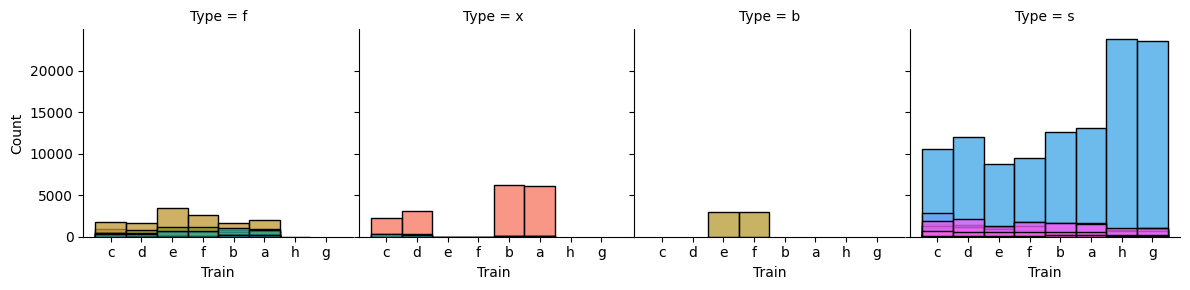

In [22]:
from traitlets.traitlets import Long

# Showing Quantity Product type made by train
g = sns.FacetGrid(df, col="Type",  hue="Prod_ID", margin_titles=True, height = 3)
g.map(sns.histplot, "Train")
g.figure.subplots_adjust(wspace=.02, hspace=.02)
# Show plot
plt.show()

#### Análisis

*   Podemos observar que el tipo de producto más fabricado es $S$ y se fabrica en todos los trenes.
*   El producto tipo *f* se produce en menor medida y no se fabrica en los trenes $h,g$
*   El producto tipo $x$ sólo se fabrica en los trenes $(c,d,b,a)$, no se fabrica en los trenes $e,f,h,g$

### Distribución de Productos (Product_ID) agrupada por Tren de producción (Train).

Se presentan subplots que representarán la frecuencia de los Productos (por ID) en cada tren 

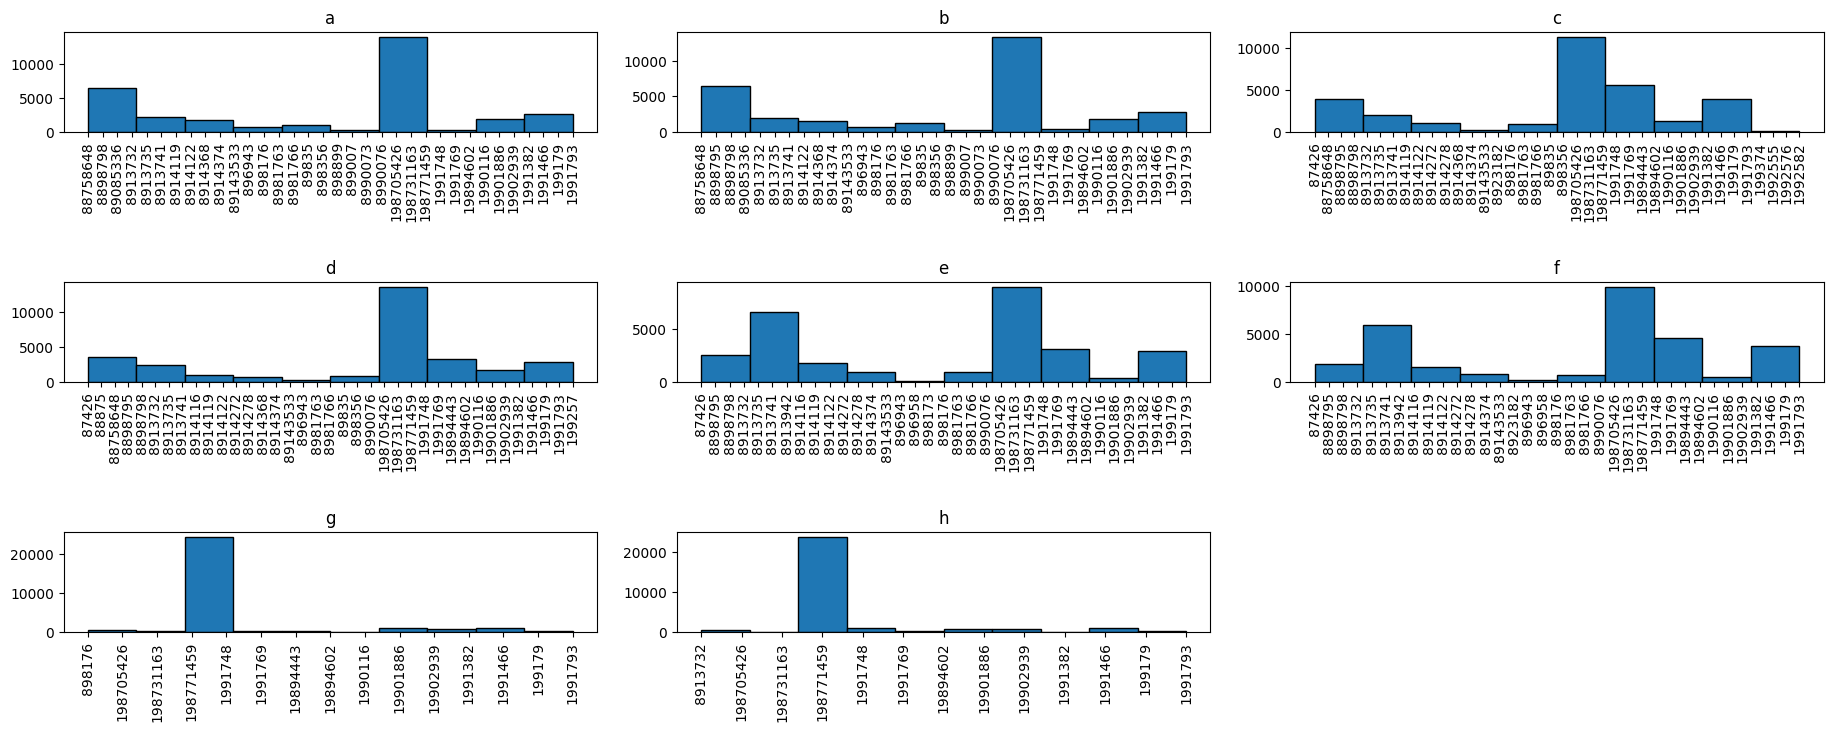

In [23]:
from IPython.core.interactiveshell import softspace
#create histograms of points by Type
df['Prod_ID'].hist(by=df['Train'], edgecolor='black', figsize = (22,8))
# Ajustar la separación entre los histogramas
plt.subplots_adjust(hspace=1.5, wspace=0.15)  # hspace controla la separación vertical y wspace la horizontal
# Mostrar el gráfico
plt.show()

## Preparacion de datos
### Eventos

In [24]:
# definir nuevo dataframe para los eventos
df_events = pd.DataFrame()

# llevar a eventos los registros de tiempo del dataset original
#df_events = df.iloc[:, 1:2].drop_duplicates().reset_index(drop=True)
df_events = df['DateTime'].drop_duplicates().sort_values(ascending=True).reset_index(drop=True).to_frame()

# Definir que la columna 'DateTime' sea en formato datetime
df_events["DateTime"] = pd.to_datetime(df_events["DateTime"])

# divisiones del año
df_events["Year"]      = df_events["DateTime"].dt.year      # Año
df_events["Quarter"]   = df_events["DateTime"].dt.quarter   # cada trimestre
df_events["Month"]     = df_events["DateTime"].dt.month    # Mes
df_events["MonthName"] = df_events["DateTime"].dt.month_name()    # Nombre del día del mes

# divisiones del mes
df_events["Week"]      = df_events["DateTime"].dt.isocalendar().week
df_events["WeekDay"]   = df_events["DateTime"].dt.weekday  # Día de la semana (0 = Lunes, 6 = Domingo)
df_events["DayOfYear"] = df_events["DateTime"].dt.dayofyear  # Día del año
df_events["Day"]       = df_events["DateTime"].dt.day  # Día del mes
df_events["DayName"]   = df_events["DateTime"].dt.day_name()   # Nombre del día de la semana

# divisiones del día 
df_events["Hour"]      = df_events["DateTime"].dt.hour
df_events["Minute"]    = df_events["DateTime"].dt.minute
df_events["Second"]    = df_events["DateTime"].dt.second

# Definir el turno de trabajo
df_events["Shift_8H"] = np.select(
    [
        (df_events["Hour"] >= 6) & (df_events["Hour"] < 14),
        (df_events["Hour"] >= 14) & (df_events["Hour"] < 22)
    ],
    [1, 2],
    default=3
)

# Crear formato de fecha
df_events["Formatted_Timestamp"] = df_events["DateTime"].dt.strftime('%Y%m%d%H%M%S')


In [25]:
df_events.tail(10)

,DateTime,Year,Quarter,Month,MonthName,Week,WeekDay,DayOfYear,Day,DayName,Hour,Minute,Second,Shift_8H,Formatted_Timestamp
227195,2025-02-28 17:50:51+00:00,2025,1,2,February,9,4,59,28,Friday,17,50,51,2,20250228175051
227196,2025-02-28 17:51:04+00:00,2025,1,2,February,9,4,59,28,Friday,17,51,4,2,20250228175104
227197,2025-02-28 18:16:45+00:00,2025,1,2,February,9,4,59,28,Friday,18,16,45,2,20250228181645
227198,2025-02-28 18:21:05+00:00,2025,1,2,February,9,4,59,28,Friday,18,21,5,2,20250228182105
227199,2025-02-28 18:22:54+00:00,2025,1,2,February,9,4,59,28,Friday,18,22,54,2,20250228182254
227200,2025-02-28 18:23:03+00:00,2025,1,2,February,9,4,59,28,Friday,18,23,3,2,20250228182303
227201,2025-02-28 18:23:11+00:00,2025,1,2,February,9,4,59,28,Friday,18,23,11,2,20250228182311
227202,2025-02-28 18:42:21+00:00,2025,1,2,February,9,4,59,28,Friday,18,42,21,2,20250228184221
227203,2025-02-28 18:47:19+00:00,2025,1,2,February,9,4,59,28,Friday,18,47,19,2,20250228184719
227204,2025-02-28 19:42:59+00:00,2025,1,2,February,9,4,59,28,Friday,19,42,59,2,20250228194259


In [26]:
print(df_events.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227205 entries, 0 to 227204
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   DateTime             227205 non-null  datetime64[ns, UTC]
 1   Year                 227205 non-null  int32              
 2   Quarter              227205 non-null  int32              
 3   Month                227205 non-null  int32              
 4   MonthName            227205 non-null  object             
 5   Week                 227205 non-null  UInt32             
 6   WeekDay              227205 non-null  int32              
 7   DayOfYear            227205 non-null  int32              
 8   Day                  227205 non-null  int32              
 9   DayName              227205 non-null  object             
 10  Hour                 227205 non-null  int32              
 11  Minute               227205 non-null  int32              
 12  Se

### Producto

In [27]:
# definir nuevo dataframe para las variantes de producto,esto mapeará
# los productos únicos con un nombre de producto único para mejorar la lectura,
# mientras se mantiene el ID original para referencias

df_Prods = pd.DataFrame()

# llevar a poructos los registros ddistintos del dataset original
df_Prods = df['Prod_ID'].drop_duplicates().sort_values(ascending=False).reset_index(drop=True).to_frame()

# Crear una nueva columna 'Producto' con el formato "producto_x" donde x es el índice
df_Prods['Product_name'] = 'Product_' + df_Prods.index.astype(str)

df_Prods.head(10)

,Prod_ID,Product_name
0,8990076,Product_0
1,8990073,Product_1
2,899007,Product_2
3,898899,Product_3
4,898356,Product_4
5,89835,Product_5
6,8981766,Product_6
7,8981763,Product_7
8,898176,Product_8
9,898173,Product_9


In [28]:
print(df_Prods.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Prod_ID       50 non-null     object
 1   Product_name  50 non-null     object
dtypes: object(2)
memory usage: 932.0+ bytes
None


In [29]:
# filtra únicamente las columnas categóricas necesarias
df_sub = df[['ID', 'DateTime', 'Type', 'Train', 'Prod_ID']].copy().sort_values(by=['DateTime'], ascending=True)

# Asegúrate de que 'DateTime' esté en formato datetime
df_sub['DateTime'] = pd.to_datetime(df_sub['DateTime'])

# De nuevo cambio de nombre columna ID  para mejorar la lectura
df_sub = df_sub.rename(columns={'ID': 'Lot_ID'})

# De nuevo cambio de nombre columna ID  para mejorar la lectura
df_sub = df_sub.rename(columns={'Train': 'Train_ID'})

# se decide renombrar los productos, esto ayuda a mejorar la lectura de los datos
df_sub = df_sub.merge(df_Prods, left_on='Prod_ID', right_on='Prod_ID', how='left')

# Diccionario de mapeo de los trenes de producción
mapping_train = {
    'a': 'Train_1',
    'b': 'Train_2',
    'c': 'Train_3',
    'd': 'Train_4',
    'e': 'Train_5',
    'f': 'Train_6',
    'g': 'Train_7',
    'h': 'Train_8'
}

df_sub['Train'] = df_sub['Train_ID'].map(mapping_train)


# Agrupar por 'ID' y obtener la fecha mínima (primera) y la fecha máxima (última)
df_Lots = df_sub.groupby('Lot_ID', as_index=False).agg(
    Type         = ('Type', 'first'),
    Train_ID     = ('Train_ID', 'first'),
    Train        = ('Train', 'first'),
    Prod_ID      = ('Prod_ID', 'first'),
    Product_name = ('Product_name', 'first'),
    First_Date   = ('DateTime', 'min'),
    Last_Date    = ('DateTime', 'max')
)

# Ordenar el DataFrame resultante de forma descendente por 'first_date'
df_Lots = df_Lots.sort_values(by='First_Date', ascending=True).reset_index(drop=True)

# Calcular la duración como la diferencia entre last_date y first_date
df_Lots['Duration'] = df_Lots['Last_Date'] - df_Lots['First_Date']

# Calcular la duración como la diferencia entre last_date y first_date
df_Lots['Formatted_Timestamp'] = df_Lots["First_Date"].dt.strftime('%Y%m%d%H%M%S')

df_Lots.head(5)

,Lot_ID,Type,Train_ID,Train,Prod_ID,Product_name,First_Date,Last_Date,Duration,Formatted_Timestamp
0,la2afjjjp,s,g,Train_7,198771459,Product_47,2023-07-14 01:16:25+00:00,2023-07-14 02:25:31+00:00,0 days 01:09:06,20230714011625
1,464afjjjp,s,a,Train_1,198771459,Product_47,2023-07-14 01:30:25+00:00,2023-07-14 03:16:52+00:00,0 days 01:46:27,20230714013025
2,keeafjjjq,s,b,Train_2,198771459,Product_47,2023-07-14 03:14:47+00:00,2023-07-14 04:25:44+00:00,0 days 01:10:57,20230714031447
3,4h2afjjjq,s,e,Train_5,1991748,Product_39,2023-07-14 03:29:23+00:00,2023-07-14 05:48:52+00:00,0 days 02:19:29,20230714032923
4,rsuafjjjq,s,c,Train_3,1991466,Product_40,2023-07-14 03:42:39+00:00,2023-07-14 06:16:54+00:00,0 days 02:34:15,20230714034239


In [30]:
print(df_Lots.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14857 entries, 0 to 14856
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   Lot_ID               14857 non-null  object             
 1   Type                 14857 non-null  object             
 2   Train_ID             14857 non-null  object             
 3   Train                14857 non-null  object             
 4   Prod_ID              14857 non-null  object             
 5   Product_name         14857 non-null  object             
 6   First_Date           14857 non-null  datetime64[ns, UTC]
 7   Last_Date            14857 non-null  datetime64[ns, UTC]
 8   Duration             14857 non-null  timedelta64[ns]    
 9   Formatted_Timestamp  14857 non-null  object             
dtypes: datetime64[ns, UTC](2), object(7), timedelta64[ns](1)
memory usage: 1.1+ MB
None


In [31]:
# definir nuevo dataframe para los Lotes
df_EU= pd.DataFrame()

# llevar a eventos los registros de tiempo del dataset original
df_EU = df['EU'].drop_duplicates().sort_values(ascending=False).reset_index(drop=True).to_frame()

df_EU = df_EU.rename(columns={'EU': 'EU_ID'})

# Crear una nueva columna 'Producto' con el formato "producto_x" donde x es el índice
df_EU['EU_name'] = 'EU_' + df_EU.index.astype(str)

# Diccionario de mapeo de unidades a descripciones
mapping_desc = {
    'seg': 'waittime',
    'ph': 'acidity',
    'kg/l': 'density',
    'kg': 'weight',
    'cp': 'viscosity',
    'c': 'temperature',
    '': 'no assigned'
}

# Diccionario de mapeo de unidades a tipo
mapping_type = {
    'seg': 'phase',
    'ph': 'control',
    'kg/l': 'control',
    'kg': 'phase',
    'cp': 'control',
    'c': 'phase',
     '': 'phase'
}

df_EU['Description'] = df_EU['EU_ID'].map(mapping_desc)
df_EU['Type'] = df_EU['EU_ID'].map(mapping_type)

df_EU.head(10)

,EU_ID,EU_name,Description,Type
0,seg,EU_0,waittime,phase
1,ph,EU_1,acidity,control
2,kg/l,EU_2,density,control
3,kg,EU_3,weight,phase
4,cp,EU_4,viscosity,control
5,c,EU_5,temperature,phase
6,,EU_6,no assigned,phase


In [32]:
print(df_EU.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   EU_ID        7 non-null      object
 1   EU_name      7 non-null      object
 2   Description  7 non-null      object
 3   Type         7 non-null      object
dtypes: object(4)
memory usage: 356.0+ bytes
None


In [33]:
# definir nuevo dataframe para los eventos
df_phases = pd.DataFrame()

# llevar a eventos los registros de tiempo del dataset original
#df_events = df.iloc[:, 1:2].drop_duplicates().reset_index(drop=True)
df_phases =  df[['DateTime', 'Unit', 'Phase_ID','Value','EU','ID']].copy().sort_values(by=['DateTime'], ascending=True)

df_phases["DateTime"] = pd.to_datetime(df_phases["DateTime"])

# Calcular la duración como la diferencia entre last_date y first_date
df_phases['Formatted_Timestamp'] = df_phases["DateTime"].dt.strftime('%Y%m%d%H%M%S')
df_phases

,DateTime,Unit,Phase_ID,Value,EU,ID,Formatted_Timestamp
79486,2023-07-14 01:16:25+00:00,tmx,md1m66,0.999945,kg,la2afjjjp,20230714011625
197055,2023-07-14 01:16:26+00:00,tmx,mtmp,0.331113,c,la2afjjjp,20230714011626
82428,2023-07-14 01:17:10+00:00,tmx,mad7428,1.000000,kg,la2afjjjp,20230714011710
88312,2023-07-14 01:17:51+00:00,tmx,maw6543,0.999782,kg,la2afjjjp,20230714011751
92735,2023-07-14 01:18:31+00:00,pwt,mk0404,0.997333,kg,la2afjjjp,20230714011831
...,...,...,...,...,...,...,...
181593,2025-02-28 18:23:03+00:00,tmx,mtds,0.957143,,n96agddj7,20250228182303
23344,2025-02-28 18:23:11+00:00,tmx,maf6833,0.999990,kg,w3magddj7,20250228182311
23513,2025-02-28 18:42:21+00:00,pwt,md1m66,1.002767,kg,w3magddj7,20250228184221
156342,2025-02-28 18:47:19+00:00,tmx,magt,0.430000,,w3magddj7,20250228184719


In [34]:
print(df_phases.info())

<class 'pandas.core.frame.DataFrame'>
Index: 236176 entries, 79486 to 215775
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   DateTime             236176 non-null  datetime64[ns, UTC]
 1   Unit                 236176 non-null  object             
 2   Phase_ID             236176 non-null  object             
 3   Value                236176 non-null  float64            
 4   EU                   236176 non-null  object             
 5   ID                   236176 non-null  object             
 6   Formatted_Timestamp  236176 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(5)
memory usage: 14.4+ MB
None
